# County-level Covid-19 Analysis for US States

This notebook utilizes data kindly made available by the JHU Systems Group at 
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

and used for their 
[Visual Dashboad](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).  It provides a temporal perspective that complements their excellent geospatial presentation.  

The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/US-covid19-JHU.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/US-covid19-JHU.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=US-covid19-JHU.ipynb)
  
## Quick links to sections

* [Cases by state](#sectionCases)
* [Deaths by state](#sectionDeaths)
* [Growth trends by state](#sectionGrowth)
* [Cases one state](#sectionOneState)
* [Projection of cases in one state](#sectionProj)
* [Projection of deaths in one state](#sectionProjDeath)

The dataset only contains confirmed cases and death, not recoveries.  The data on recoveries tends not to be very good anyways, because case tracking is so poor.  But more importantly, the level of penetration of the virus is still in such an early stage that the eventual balancing out in the SIR models is irrelevant.  With infections growing at 15% per day, if all of today's cases recovered two weeks out, it would only be 1/16th of the new cases.  We are looking at days and weeks, not months and years.

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [65]:
# A week, A month, two weeks out ...
1.25**7, 1.25**31, 1.15*14

(4.76837158203125, 1009.7419586828951, 16.099999999999998)

In [66]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [67]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%m/%d/%y"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

In [68]:
def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    vals = [x for x in trend.take[-window:]['rate'] if np.isfinite(x)]
    return scipy.stats.gmean(vals)


def project_trend(trend, num_days, rate=None, window=4):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend, window)
        
    day = trend.last('date')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [69]:
# Tools specific to the notebook analysis

def make_pname(root, prev):
    return root + "-" + str(prev)

def proj_timeseries(ts, region, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    return project_trend(ts.extract(region).trend(), dist).select(['date', region, 'new'])

def proj2_timeseries(ts, region, prev=2, dist=14, end=None,):
    if not end:
        end = ts['date'][-1]
    proj  = project_trend(ts.extract(region).tail(7+prev).trend(), dist).select(['date', region, 'new'])
    proj1 = project_trend(ts.extract(region).tail(7, prev).trend(), dist+prev).select(['date', region, 'new'])
    proj1.relabel(region, make_pname(region, prev))
    proj1.relabel('new',  make_pname('new', prev))
    combined = TimeTable.from_table(proj.join('date', proj1), time_col = 'date')
    return combined

def proj(ts, region, prev=7, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    proj = proj_timeseries(ts, region, dist, end)
    proj.tail(dist).show()
    proj.select(['date', region, 'new']).tail(prev+dist).plot('date', width = 7)
    plots.plot([end, end], [0, ts[region][-1]])
    _ = plots.xticks(rotation=90)
    
def proj2(ts, region, prev=2, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    pend = inc_day(end, -prev)
    combined = proj2_timeseries(ts, region, prev, dist, end)
    combined.oplot(height=6, width=6)
    plots.plot([end, end], [0, combined[region][-1]])
    pname = make_pname(region, prev)
    plots.plot([pend, pend], [0, combined[pname][-1]])
    plots.text(end, combined[region][-dist], "{:,}".format(int(combined[region][-dist])))
    plots.text(end, combined[region][-1], "{:,}".format(int(combined[region][-1])))
    plots.text(pend, combined[region][-dist-prev], "{:,}".format(int(combined[region][-dist-prev])))
    plots.text(pend, combined[pname][-1], "{:,}".format(int(combined[pname][-1])))
    combined.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))
    _ = plots.xticks(rotation=90)
    
def get_rates(ts):
    trends = ts.trend()
    rates = trends.extract([x for x in trends.labels if 'rate' in x])
    for label in rates.categories :
        rates.relabel(label, label[5:])
    return rates

In [70]:
def exp_rate(days, s, r):
    return [s*r**day for day in days]

def lin_rate(days, s, r):
    return [s + r*day for day in days]

def fit(model, trend):
    """Fit a 2 paramater model to a rate trend"""
    try :
        doffs = list(range(trend.num_rows))
        params, pcov = scipy.optimize.curve_fit(model, doffs, trend['rate'])
        return params, np.sqrt(np.diag(pcov))
    except :
        return [np.nan, np.nan], [np.nan, np.nan]

def model_rate_trend(trend):
    eparams, epcov = fit(exp_rate, trend)
    doffs = list(range(trend.num_rows))
    t1 = trend.with_column('exp pred', exp_rate(doffs, eparams[0], eparams[1]))
    lparams, lpcov = fit(lin_rate, trend)
    t2 = t1.with_column('lin pred', lin_rate(doffs, lparams[0], lparams[1]))
    return t2, eparams, lparams

def show_model_rate_trend(trend):
    mtrend, eparams, lparams = model_rate_trend(trend)
    print(eparams, lparams)
    mtrend.extract(['exp pred', 'lin pred']).oplot(width=8)
    _ = plots.xticks(rotation=90)
    mtrend.plots[-1].scatter(mtrend['date'], mtrend['rate'])
    mtrend.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

In [71]:
# Daily growth rates

def wgmean(vals):
    xvals = [x for x in vals if np.isfinite(x)]
    try :
        return scipy.stats.gmean(xvals) if xvals else np.nan
    except :
        return np.nan

def growth_rate(trend, window=3):
    """Smooth raw rates"""
    rates = trend['rate']
    vals = np.array((window-1)*[np.nan] + list(rates))
    return [wgmean(vals[i:i+window]) for i in range(len(rates))]

def plot_rate_trend(trend):
    trend = trend.with_column('gm_rate', growth_rate(trend))
    trend.extract(['gm_rate']).oplot(width=8)
    _ = plots.xticks(rotation=90)
    trend.plots[-1].scatter(trend['date'], trend['rate'])
    trend.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(25))

## Pull Data

URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [72]:
stateCasesURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv" 
stateDeathsURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv" 

In [73]:
raw_states_cases = Table.read_table(stateCasesURL)
raw_states_deaths = Table.read_table(stateDeathsURL)

In [74]:
# Number of Counties
states = list(np.unique(raw_states_cases['Province_State']))
US_counties = list(np.unique(raw_states_cases['Admin2']))
len(states), len(US_counties)

(58, 1894)

<a id='selectState'></a>
## Select state to examine at county level

Choose a state and run all cells below.

In [75]:
w = widgets.Dropdown(
    options = states,
    value ='California',
    # rows=10,
    description='State:',
    disabled=False
)
w

Dropdown(description='State:', index=5, options=('Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',…

In [76]:
state = w.value
raw_state_cases = raw_states_cases.where('Province_State', state)
raw_state_deaths = raw_states_deaths.where('Province_State', state)

In [77]:
raw_state_cases

UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
84006001,US,USA,840,6001,Alameda,California,US,37.6463,-121.893,"Alameda, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,3,5,5,7,11,11,18,27,30,38,48,68,71,118,135,135,178,220,220,270,283,313,313,359,443,443,566,588,634,674,674,766,806
84006003,US,USA,840,6003,Alpine,California,US,38.5968,-119.822,"Alpine, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2
84006005,US,USA,840,6005,Amador,California,US,38.4458,-120.657,"Amador, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,3,3,3,0,3,3,3,3,7,7
84006007,US,USA,840,6007,Butte,California,US,39.6673,-121.601,"Butte, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,4,5,5,5,5,5,8,8,9,10,11,11,11,12,13,13,13,14
84006009,US,USA,840,6009,Calaveras,California,US,38.2054,-120.553,"Calaveras, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,4,4,5,5,5,5,8,8
84006011,US,USA,840,6011,Colusa,California,US,39.1788,-122.233,"Colusa, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,3,3,3,3
84006013,US,USA,840,6013,Contra Costa,California,US,37.9192,-121.929,"Contra Costa, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,9,9,9,10,17,25,29,29,34,39,39,41,46,51,61,71,86,108,131,147,168,168,187,212,249,250,307,307,386,417,442,462,484,511,530
84006015,US,USA,840,6015,Del Norte,California,US,41.7423,-123.897,"Del Norte, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2
84006017,US,USA,840,6017,El Dorado,California,US,38.7797,-120.523,"El Dorado, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,9,12,12,12,15,18,18,19,22,22,22,22,28,29,30,32
84006019,US,USA,840,6019,Fresno,California,US,36.7573,-119.647,"Fresno, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,1,1,1,2,2,2,3,6,6,6,6,13,18,19,27,31,43,43,53,68,82,94,100,103,108,124,146,156,173,191


In [78]:
county_population = raw_state_deaths.select(['Admin2', 'Population'])
county_population.relabel('Admin2', 'County')

County,Population
Alameda,1671329
Alpine,1129
Amador,39752
Butte,219186
Calaveras,45905
Colusa,21547
Contra Costa,1153526
Del Norte,27812
El Dorado,192843
Fresno,999101


In [79]:
def population(county):
    return county_population.where('County', county)['Population'][0]

In [80]:
population('Del Norte')

27812

In [81]:
def by_county_cases(raw_region):
    """Aggregate county level data from the raw state source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 
                           'Province_State',
                           'Country_Region', 'Lat','Long_', 
                           'Combined_Key'])
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl))
    return res

def by_county_deaths(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 
                           'Province_State', 'Population',
                           'Country_Region', 'Lat','Long_', 
                           'Combined_Key'])
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl))
    return res

In [82]:
cases_by_county = by_county_cases(raw_state_cases)
deaths_by_county = by_county_deaths(raw_state_deaths)

In [83]:
cases = TimeTable.transpose(cases_by_county, 'Admin2', time_col='date', time_less = less_day, time_inc = inc_day)
deaths = TimeTable.transpose(deaths_by_county, 'Admin2', time_col='date', time_less = less_day, time_inc = inc_day)
counties = cases.categories

In [84]:
# Last day of rerported data
last_day = cases['date'][-1]
last_day

'04/11/20'

In [85]:
# Number of counties reported
len(counties)

60

## State-wide picture

The following graph shows the state picture since the early cases were reported.  States began putting [shelter-in-place measures](https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html) 
in effect March 19 (for California, March 17 for 6 of its counties).

Looking at just the overall number of cases that is when Covid-19 took off in scale.

In [86]:
state

'California'

In [87]:
state_cases = cases.select(cases.time_column)
state_cases[state] = cases.sum_cols()

state_deaths = deaths.select(cases.time_column)
state_deaths[state] = deaths.sum_cols()

state_population = sum(county_population['Population'])

In [88]:
# percentage of the population confirmed
"{} confirmed cases: {:,} - {:.3%} of {:,} population".format(state, 
                                                              state_cases.last(state), 
                                                              state_cases.last(state) / state_population, 
                                                              state_population)

'California confirmed cases: 21,706 - 0.055% of 39,512,223 population'

In [89]:
state_deaths.last(state), state_deaths.last(state)/state_population

(605, 1.5311717591794315e-05)

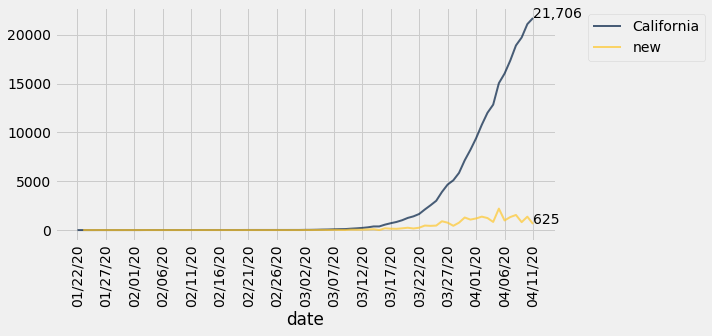

In [90]:
state_case_trend = state_cases.trend()
state_all = state_case_trend.extract([state, 'new'])
state_all.oplot(width=8)
_ = plots.xticks(rotation=90)
plots.text(state_all.last('date'), state_all.last(state), "{:,}".format(state_all.last(state)))
plots.text(state_all.last('date'), state_all.last('new'), "{:,}".format(int(state_all.last('new'))))
state_all.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

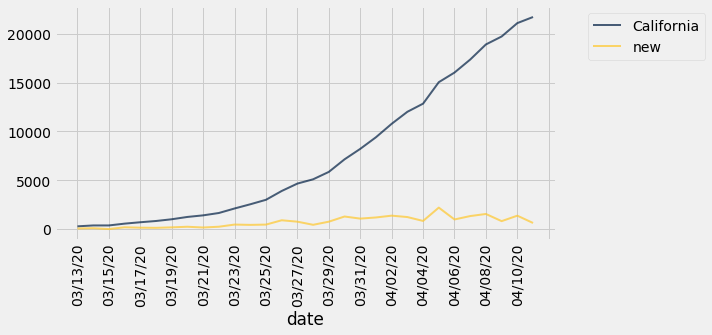

In [91]:
recent = state_case_trend.extract([state, 'new']).after("03/13/20")
recent.oplot(width=8)
_ = plots.xticks(rotation=90)
recent.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

## Growth Rates

A much deeper picture is revealed by looking at the day-over-day growth rates across the overall course of the infection.

The daily growth rate had shot up to as muchj as 50% new cases per day for two weeks before the states finally took action.

Since that time it has been dropping steadily as the measures became broader and more consistent.  While still way to fast for the health care systems to manage, it the difference is immense.  At 17% dailey, the number of cases grows by an order of magnitude over two weeks, instead of one,

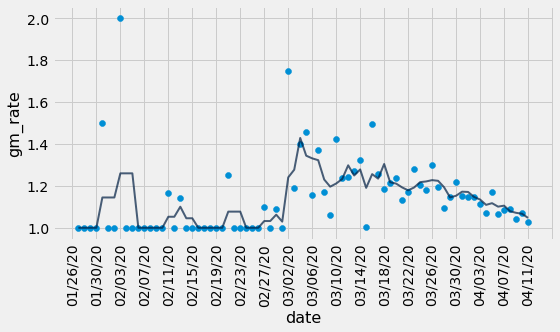

In [92]:
plot_rate_trend(state_case_trend)

Looking at the period since mitigation measures, we find a steadily enough trend that we can hope to model the future enough to attempt predictions.

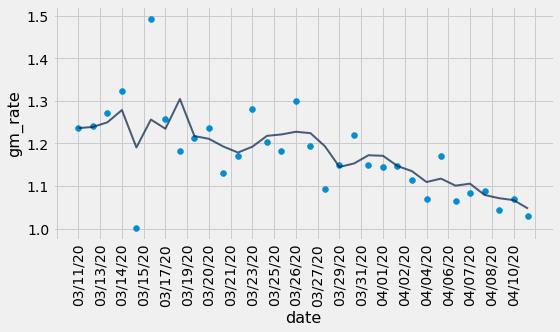

In [93]:
# Past month
plot_rate_trend(state_case_trend.tail(31))

Taking just the past two weeks, we can get a good fit.  What we are observing here is not the properties of viral infections processes, such as SIR models as more and more of the population gains immunities, it is fundamentally the reduction in transmission rates due to human behavior.  We are still at such minute level of immunity in the population that the classic epidemiological factors hardly matter.  

The challenge is what properties should we imbue to such human behavior?  Can we expect linear improvements or is the improvement a continued reduction in the oustanding rate, i.e., exponential.  Over the short term, these cannot be meaningfully differentiated.  Clearly the linear model goes negative whereas the exponential model gradually converges to zero.  

Law of small numbers and vagaries in rerporting make the daily reports pretty noisy.  But for larger states farther into the epidemic, the trends appears clear.  
The trends are so slow that we need to go out a month or to see a notable difference.

[1.16812941 0.9925626 ] [ 1.1677852  -0.00836569]


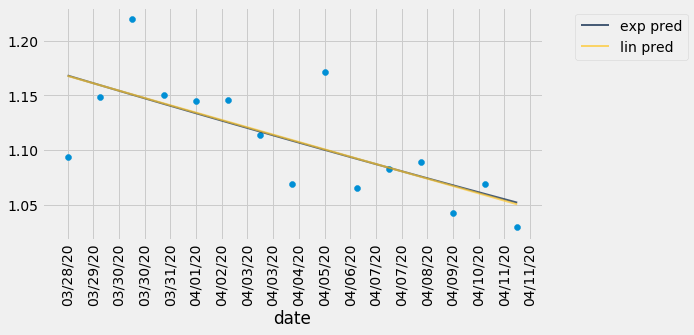

In [94]:
show_model_rate_trend(state_case_trend.tail(14))

In [95]:
state_rate_proj, eparams, lparams = model_rate_trend(state_case_trend.tail(14))

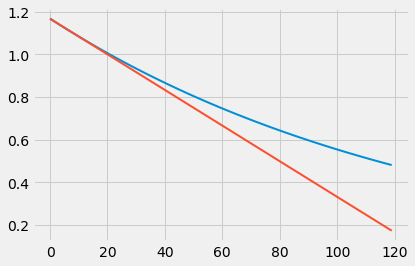

In [96]:
def ahead(n):
    plots.plot(exp_rate(range(n), eparams[0], eparams[1]))
    plots.plot(lin_rate(range(n), lparams[0], lparams[1]))

ahead(120)

## State Projections

Given some predictability, we can project grow rates into the future.  First we look projecting based on the current daily growth rate, modeling what things look like if we do just what we are seeing today, versus how they looked based on what we were seeing some days previously.

Then, given the steady reduction in rates, we project based on projecting the rate improving exponentially.

In [97]:
# Prediction going forward assuming the growth rate remains as it is currently

def proj_state(prev=2, dist=14):
    proj2(state_cases, state, prev, dist)
    
_ = interact(proj_state, prev=(0,7,1), dist = (3, 14, 1))

interactive(children=(IntSlider(value=2, description='prev', max=7), IntSlider(value=14, description='dist', m…

In [98]:
def project_progressive_trend(trend, region, num_days):
    day = trend.last(trend.time_column)
    val = trend.last(region)
    new = trend.last('new')
    rate = trend.last('rate')
    params, pcov = fit(exp_rate, trend)
    growths = exp_rate(range(num_days+1), rate, params[1])
    
    proj = trend.select([trend.time_column, region, 'new', 'rate'])
    for i in range(num_days):
        day = inc_day(day)
        rate = growths[i+1]
        new = rate*new
        val = val + new
        pnew = new/val
        proj.append((day, val, new, rate))
    return proj

def proj_prog(ts, region, prev=7, dist=14):
    trend = ts.trend().tail(prev)
    proj = project_progressive_trend(trend, region, dist)
    pproj = proj.select([proj.time_column, region, 'new']).tail(prev+dist)
    pproj.plot('date', width = 8)
    end = trend.last(trend.time_column)
    plots.plot([end, end], [0, trend.last(region)])
    pproj.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(25))
    plots.text(end, trend.last(region), "{:,}".format(trend.last(region)))
    plots.text(pproj.last('date'), pproj.last(region), "{:,}".format(int(pproj.last(region))))
    _ = plots.xticks(rotation=90)

In [99]:
def pproj_state(prev=14, dist=14):
    proj_prog(state_cases, state, prev, dist)
    
_ = interact(pproj_state, prev=(0,14,1), dist = (3, 45, 1))



interactive(children=(IntSlider(value=14, description='prev', max=14), IntSlider(value=14, description='dist',…

In [100]:
project_progressive_trend(state_cases.trend().tail(7), state, 14).show()

date,California,new,rate
04/04/20,12837,833,1.06939
04/05/20,15034,2197,1.17115
04/06/20,16019,985,1.06552
04/07/20,17351,1332,1.08315
04/08/20,18897,1546,1.0891
04/09/20,19710,813,1.04302
04/10/20,21081,1371,1.06956
04/11/20,21706,625,1.02965
04/12/20,22343.6,637.565,1.0201
04/13/20,22987.9,644.355,1.01065


<a id=sectionCases></a>
## Cases to date by County

The following shows the state picture built up county by county.  Only the largest are shown, with the remainder
grouped into 'other'.

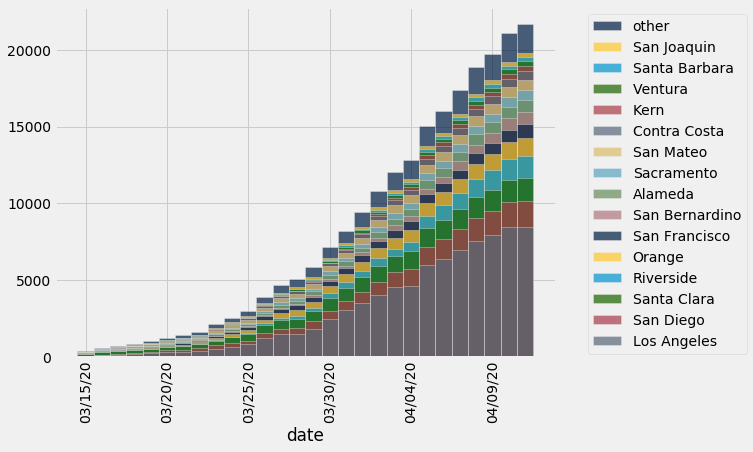

In [101]:
cases.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

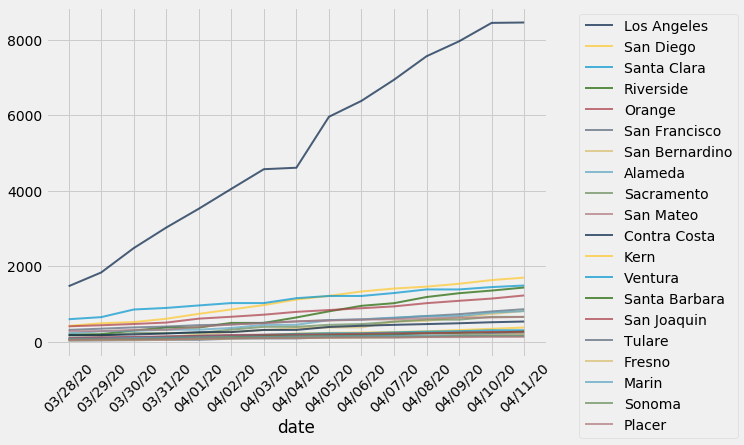

In [102]:
# Cases by county over the past two weeks
cases.top(20).tail(14).plot('date', width=8, height=6)
_ = plots.xticks(rotation=45)

In [103]:
def cases_since(ts, region, threshold=100):
    ctbl = ts.extract(region)
    since = ctbl.where(ctbl[region] >= threshold)
    ndays = since.num_rows
    vals = since[region]
    return vals
        
def show_cases_since(ts, threshold=100, width=8, height=6):
        _, axis = plots.subplots(figsize=(width, height))
        for region in ts.categories :
            vals = cases_since(ts, region, threshold)
            axis.plot(vals)
            axis.text(len(vals), vals[-1], region)

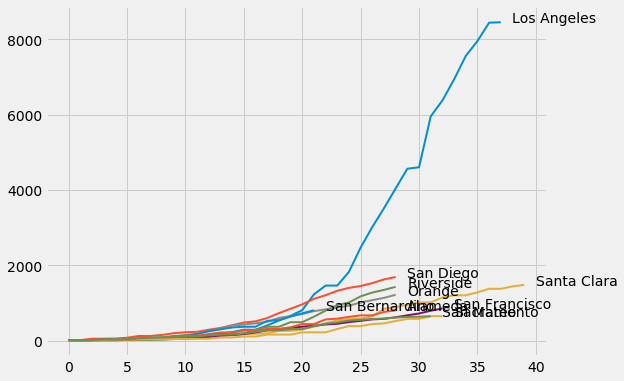

In [104]:
show_cases_since(cases.top(10), 10)

In [105]:
def norm_by_population(ts):
    """Normalize region counts by population in percent"""
    normed = ts.select(ts.time_column)
    for region in ts.categories :
        if population(region) :
            normed[region] = 100*ts[region]/population(region)
    return normed

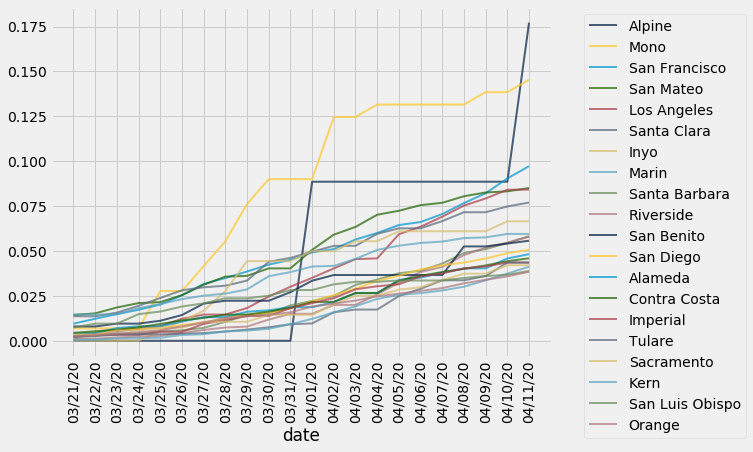

In [106]:
norm_by_population(cases).tail(21).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

<a id='sectionTrends'></a>
## Growth trends by County

An important caveat is that the dirth of testing makes the number of report cases, and particularly the change in that number, messy.  Increased test coverage will tend to increase the number of confirmed cases, whereas containment and mitigation measures may actually be reducing the spread.

The `% new` columns simply look at what fraction of a day's cases are newly reported in that day.  The `rate` columns take the geometric mean of ratio of successive days over a window of the past few days. This provides a little smoothing, but it does not try to project changes in rate.  That is reflected in the series of rates.  Modulo the testing factors, this provides some indication of where measures are working or not.

Death rates are relatively insensitive to the testing error, but are such a lagging indicator they have a limited role in setting expectations for case loads.

In [107]:
cases.order_cols().trend().tail(7)

date,Los Angeles,new Los Angeles,% newLos Angeles,rate Los Angeles,San Diego,new San Diego,% newSan Diego,rate San Diego,Santa Clara,new Santa Clara,% newSanta Clara,rate Santa Clara,Riverside,new Riverside,% newRiverside,rate Riverside,Orange,new Orange,% newOrange,rate Orange,San Francisco,new San Francisco,% newSan Francisco,rate San Francisco,San Bernardino,new San Bernardino,% newSan Bernardino,rate San Bernardino,Alameda,new Alameda,% newAlameda,rate Alameda,Sacramento,new Sacramento,% newSacramento,rate Sacramento,San Mateo,new San Mateo,% newSan Mateo,rate San Mateo,Contra Costa,new Contra Costa,% newContra Costa,rate Contra Costa,Kern,new Kern,% newKern,rate Kern,Ventura,new Ventura,% newVentura,rate Ventura,Santa Barbara,new Santa Barbara,% newSanta Barbara,rate Santa Barbara,San Joaquin,new San Joaquin,% newSan Joaquin,rate San Joaquin,Tulare,new Tulare,% newTulare,rate Tulare,Fresno,new Fresno,% newFresno,rate Fresno,Marin,new Marin,% newMarin,rate Marin,Sonoma,new Sonoma,% newSonoma,rate Sonoma,Placer,new Placer,% newPlacer,rate Placer,Solano,new Solano,% newSolano,rate Solano,Stanislaus,new Stanislaus,% newStanislaus,rate Stanislaus,San Luis Obispo,new San Luis Obispo,% newSan Luis Obispo,rate San Luis Obispo,Santa Cruz,new Santa Cruz,% newSanta Cruz,rate Santa Cruz,Imperial,new Imperial,% newImperial,rate Imperial,Monterey,new Monterey,% newMonterey,rate Monterey,Yolo,new Yolo,% newYolo,rate Yolo,Merced,new Merced,% newMerced,rate Merced,Humboldt,new Humboldt,% newHumboldt,rate Humboldt,Sutter,new Sutter,% newSutter,rate Sutter,San Benito,new San Benito,% newSan Benito,rate San Benito,Nevada,new Nevada,% newNevada,rate Nevada,El Dorado,new El Dorado,% newEl Dorado,rate El Dorado,Madera,new Madera,% newMadera,rate Madera,Napa,new Napa,% newNapa,rate Napa,Shasta,new Shasta,% newShasta,rate Shasta,Mono,new Mono,% newMono,rate Mono,Yuba,new Yuba,% newYuba,rate Yuba,Butte,new Butte,% newButte,rate Butte,Inyo,new Inyo,% newInyo,rate Inyo,Kings,new Kings,% newKings,rate Kings,Calaveras,new Calaveras,% newCalaveras,rate Calaveras,Amador,new Amador,% newAmador,rate Amador,Siskiyou,new Siskiyou,% newSiskiyou,rate Siskiyou,Lake,new Lake,% newLake,rate Lake,Mendocino,new Mendocino,% newMendocino,rate Mendocino,Plumas,new Plumas,% newPlumas,rate Plumas,Unassigned,new Unassigned,% newUnassigned,rate Unassigned,Colusa,new Colusa,% newColusa,rate Colusa,Glenn,new Glenn,% newGlenn,rate Glenn,Alpine,new Alpine,% newAlpine,rate Alpine,Del Norte,new Del Norte,% newDel Norte,rate Del Norte,Tehama,new Tehama,% newTehama,rate Tehama,Tuolumne,new Tuolumne,% newTuolumne,rate Tuolumne,Lassen,new Lassen,% newLassen,rate Lassen,Mariposa,new Mariposa,% newMariposa,rate Mariposa,Modoc,new Modoc,% newModoc,rate Modoc,Sierra,new Sierra,% newSierra,rate Sierra,Trinity,new Trinity,% newTrinity,rate Trinity,Out of CA,new Out of CA,% newOut of CA,rate Out of CA
04/04/20,4605,39,0.00846906,1.00854,1112,146,0.131295,1.15114,1148,129,0.112369,1.12659,638,145,0.227273,1.29412,786,75,0.0954198,1.10549,529,32,0.0604915,1.06439,353,49,0.13881,1.16118,443,0,0,1,390,0,0,1,538,52,0.0966543,1.107,307,0,0,1,210,37,0.17619,1.21387,203,26,0.128079,1.14689,152,13,0.0855263,1.09353,185,5,0.027027,1.02778,81,0,0,1,100,6,0.06,1.06383,131,13,0.0992366,1.11017,105,10,0.0952381,1.10526,97,0,0,1,73,12,0.164384,1.19672,58,7,0.12069,1.13725,93,0,0,1,59,2,0.0338983,1.03509,55,3,0.0545455,1.05769,57,4,0.0701754,1.07547,37,4,0.108108,1.12121,16,0,0,1,44,7,0.159091,1.18919,16,2,0.125,1.14286,23,0,0,1,31,1,0.0322581,1.03333,22,3,0.136364,1.15789,28,0,0,1,20,2,0.1,1.11111,12,1,0.0833333,1.09091,19,1,0.0526316,1.05556,9,1,0.111111,1.125,11,1,0.0909091,1.1,10,0,0,1,5,0,0,1,4,1,0.25,1.33333,3,0,0,1,3,0,0,1,0,0,nan,nan,4,0,0,1,2,1,0.5,2,0,0,nan,nan,2,1,0.5,2,2,0,0,1,1,0,0,1,2,1,0.5,2,1,1,1,inf,2,0,0,1,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan
04/05/20,5955,1350,0.2267,1.29316,1209,97,0.0802316,1.08723,1207,59,0.0488815,1.05139,799,161,0.201502,1.25235

In [108]:
def rate_change(ts, region_type, prev=7):
    rates   = get_rates(ts)
    regions = ts.categories
    current = rates.row(-1)[1:]
    older   = rates.row(-1-prev)[1:]
    return Table().with_columns(region_type, regions,
                                'rate', current, 
                                make_pname('rate', prev), older)

def show_rate_change(ts, region_type, prev=7):
    rc = rate_change(ts, region_type, prev)
    rc.drop(0).scatter('rate')
    plots.plot([ min(rc['rate']), max(rc['rate']) ], [ min(rc['rate']), max(rc['rate']) ])

The interactive chart below shows for each state the current growth rate (horizontal) versus the growth rate some days previous.  The distance able the line shows how much the growth rate has improved, below the line the growth rate is getting worse.  Gives a sense of how the measures are working.

In [109]:
def irate(previous=7):
    show_rate_change(cases, 'County', previous)

_ = interact(irate, previous = (1,28,1))

interactive(children=(IntSlider(value=7, description='previous', max=28, min=1), Output()), _dom_classes=('wid…

<a id=sectionDeaths></a>
## Deaths to date by state

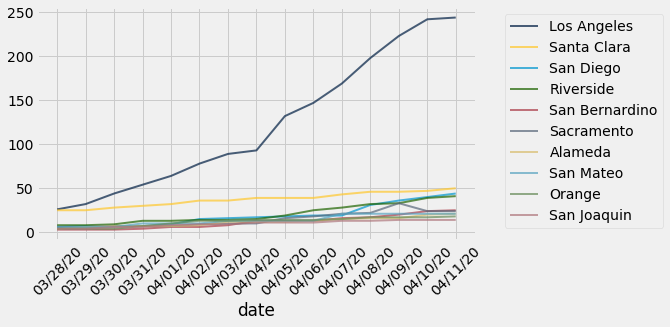

In [110]:
deaths.top(10).tail(14).plot('date', width=7)
_ = plots.xticks(rotation=45)

In [111]:
deaths.order_cols().trend().tail(7)

date,Los Angeles,new Los Angeles,% newLos Angeles,rate Los Angeles,Santa Clara,new Santa Clara,% newSanta Clara,rate Santa Clara,San Diego,new San Diego,% newSan Diego,rate San Diego,Riverside,new Riverside,% newRiverside,rate Riverside,San Bernardino,new San Bernardino,% newSan Bernardino,rate San Bernardino,Sacramento,new Sacramento,% newSacramento,rate Sacramento,Alameda,new Alameda,% newAlameda,rate Alameda,San Mateo,new San Mateo,% newSan Mateo,rate San Mateo,Orange,new Orange,% newOrange,rate Orange,San Joaquin,new San Joaquin,% newSan Joaquin,rate San Joaquin,San Francisco,new San Francisco,% newSan Francisco,rate San Francisco,Contra Costa,new Contra Costa,% newContra Costa,rate Contra Costa,Tulare,new Tulare,% newTulare,rate Tulare,Marin,new Marin,% newMarin,rate Marin,Ventura,new Ventura,% newVentura,rate Ventura,Fresno,new Fresno,% newFresno,rate Fresno,Placer,new Placer,% newPlacer,rate Placer,Imperial,new Imperial,% newImperial,rate Imperial,Kern,new Kern,% newKern,rate Kern,Merced,new Merced,% newMerced,rate Merced,Monterey,new Monterey,% newMonterey,rate Monterey,Shasta,new Shasta,% newShasta,rate Shasta,Sutter,new Sutter,% newSutter,rate Sutter,Yolo,new Yolo,% newYolo,rate Yolo,Madera,new Madera,% newMadera,rate Madera,Napa,new Napa,% newNapa,rate Napa,San Benito,new San Benito,% newSan Benito,rate San Benito,Santa Barbara,new Santa Barbara,% newSanta Barbara,rate Santa Barbara,Solano,new Solano,% newSolano,rate Solano,Sonoma,new Sonoma,% newSonoma,rate Sonoma,Mono,new Mono,% newMono,rate Mono,Nevada,new Nevada,% newNevada,rate Nevada,San Luis Obispo,new San Luis Obispo,% newSan Luis Obispo,rate San Luis Obispo,Santa Cruz,new Santa Cruz,% newSanta Cruz,rate Santa Cruz,Stanislaus,new Stanislaus,% newStanislaus,rate Stanislaus,Yuba,new Yuba,% newYuba,rate Yuba,Alpine,new Alpine,% newAlpine,rate Alpine,Amador,new Amador,% newAmador,rate Amador,Butte,new Butte,% newButte,rate Butte,Calaveras,new Calaveras,% newCalaveras,rate Calaveras,Colusa,new Colusa,% newColusa,rate Colusa,Del Norte,new Del Norte,% newDel Norte,rate Del Norte,El Dorado,new El Dorado,% newEl Dorado,rate El Dorado,Glenn,new Glenn,% newGlenn,rate Glenn,Humboldt,new Humboldt,% newHumboldt,rate Humboldt,Inyo,new Inyo,% newInyo,rate Inyo,Kings,new Kings,% newKings,rate Kings,Lake,new Lake,% newLake,rate Lake,Lassen,new Lassen,% newLassen,rate Lassen,Mariposa,new Mariposa,% newMariposa,rate Mariposa,Mendocino,new Mendocino,% newMendocino,rate Mendocino,Modoc,new Modoc,% newModoc,rate Modoc,Plumas,new Plumas,% newPlumas,rate Plumas,Sierra,new Sierra,% newSierra,rate Sierra,Siskiyou,new Siskiyou,% newSiskiyou,rate Siskiyou,Tehama,new Tehama,% newTehama,rate Tehama,Trinity,new Trinity,% newTrinity,rate Trinity,Tuolumne,new Tuolumne,% newTuolumne,rate Tuolumne,Out of CA,new Out of CA,% newOut of CA,rate Out of CA,Unassigned,new Unassigned,% newUnassigned,rate Unassigned
04/04/20,93,4,0.0430108,1.04494,39,3,0.0769231,1.08333,17,1,0.0588235,1.0625,15,1,0.0666667,1.07143,13,5,0.384615,1.625,10,0,0,1,12,0,0,1,13,0,0,1,14,1,0.0714286,1.07692,11,2,0.181818,1.22222,8,1,0.125,1.14286,5,2,0.4,1.66667,3,1,0.333333,1.5,6,0,0,1,6,0,0,1,1,1,1,inf,2,0,0,1,1,0,0,1,2,0,0,1,0,0,nan,nan,2,0,0,1,2,1,0.5,2,1,0,0,1,1,0,0,1,1,0,0,1,2,1,0.5,2,2,1,0.5,2,1,0,0,1,1,0,0,1,2,0,0,1,1,0,0,1,1,1,1,inf,0,0,nan,nan,1,0,0,1,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan,0,-2,-inf,0
04/05/20,132,39,0.295455,1.41935,39,0,0,1,18,1,0.0555556,1.05882,19,4,0.210526,1.26667,13,0,0,1,16,6,0.375,1.6,12,0,0,1,13,0,0,1,14,0,0,1,11,0,0,1,8,0,0,1,6,1,0.166667,1.2,5,2,0.4,1.66667,7,1,0.142857,1.16667,6,0,0,1,1,0,0,1,3,1,0.333333,1.5,2,1,0.5,2,2,0,0,1,0,0,nan,nan,2,0,0,1,2,0,0,1,2,1,0.5,2,1,0,0,1,2,1,0.5,2,2,0,0,1,2,0,0,1,1,0,0,1,1,0,0,1,2,0,0,1,1,0,0,1,1,

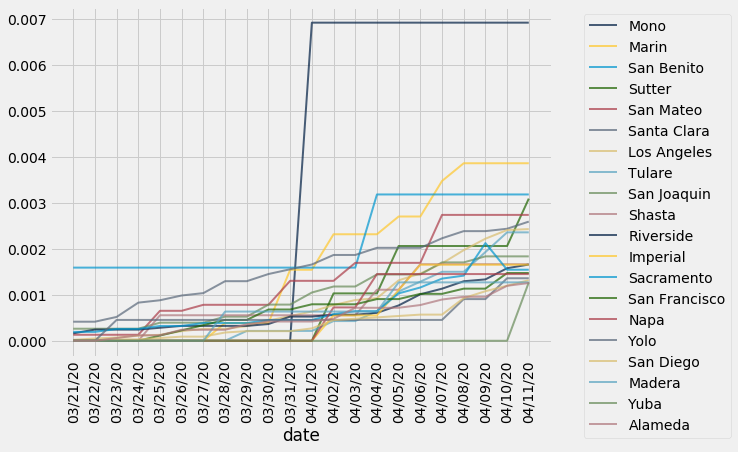

In [112]:
norm_by_population(deaths).tail(21).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

<a id='sectionOneState'></a>
## Cases in one County

These sections of the notebook allow diving into the picture for a particular county.  We start with the basic trends and then look at projects up to a couple weeks out.  Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that.  Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [113]:
def show_cty(county, prev = 7):
    cases.extract(county).trend().tail(prev).show()
    cases.extract(county).trend().extract([county, 'new']).tail(21).plot('date', width=7)
    _ = plots.xticks(rotation=90)
    plot_rate_trend(cases.extract(county).trend().tail(prev))
    _ = plots.xticks(rotation=90)

_ = interact(show_cty, county=counties, prev = (7, 21, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

<a id='sectionProj'></a>
## Projection of cases in one county

To look forward at what the story may be over the coming days, we project forward the recent growth rate.  This may be pessimistic if measures are working and the rate is improving.  But, the rate of change in the rate is low enough and the variability due to external factors high enough that any more sophisticated method seems dubious.

The vertical line shows where we are today.

In [114]:
def proj_cty(county, dist=14):
    proj(cases, county, 7, dist)
    
_ = interact(proj_cty, county=counties, dist = (7, 14, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

<a id='sectionProjDeath'></a>
## Projection of deaths in one county

In [115]:
def proj_cty_deaths(county, dist=14):
    proj(deaths, county, 7, dist)

_ = interact(proj_cty_deaths, county=counties, dist = (7, 14, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

## Are the projections changing with mitigation measures?

We are seeing reductions in growth rates as communities adopt shelter in place and other isolation measures.  How does out prediction today for two weeks out differ from what we would have made yesterday for 15 days out?  

This graph shows the project based on the most current data and compares it to the projection based on
`prev` days ago.  If measures are succeeding, we should see improvements relative to `-prev`.  The distance of projection is adjustable.

In [116]:
def proj2_cty(county, prev=2, dist=14):
    proj2(cases, county, prev, dist)
    
_ = interact(proj2_cty, county=counties, prev=(0,7,1), dist=(3, 14, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

In [117]:
def proj_prog_cty(county, dist=14):
    proj_prog(cases.extract(county), county, 7, dist)
    
_ = interact(proj_prog_cty, county=counties, dist = (7, 31, 1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

In [118]:
def proj2_cty_deaths(county, prev=2):
    proj2(deaths, county, prev)
    
_ = interact(proj2_cty_deaths, county=counties, prev=(0,7,1))

interactive(children=(Dropdown(description='county', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaver…

## Changes in case rates

Here we try to get a handle on the spread of rates and whether they are improving.

In [119]:
get_rates(cases).tail(7)

date,Alameda,Alpine,Amador,Butte,Calaveras,Colusa,Contra Costa,Del Norte,El Dorado,Fresno,Glenn,Humboldt,Imperial,Inyo,Kern,Kings,Lake,Lassen,Los Angeles,Madera,Marin,Mariposa,Mendocino,Merced,Modoc,Mono,Monterey,Napa,Nevada,Orange,Placer,Plumas,Riverside,Sacramento,San Benito,San Bernardino,San Diego,San Francisco,San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,Santa Clara,Santa Cruz,Shasta,Sierra,Siskiyou,Solano,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba,Out of CA,Unassigned
04/04/20,1,1,1,1.1,1.33333,2,1,2,1.15789,1.06383,1,1.18919,1.05769,1,1.21387,1,nan,nan,1.00854,1,1.11017,nan,1,1,nan,1.05556,1.07547,1.11111,1.03333,1.10549,1,2,1.29412,1,1,1.16118,1.15114,1.06439,1.02778,1,1.107,1.09353,1.12659,1.03509,1.09091,nan,1,1.19672,1.10526,1.13725,1.14286,inf,nan,1,1,1.14689,1.12121,1.125,nan,nan
04/05/20,1.27765,1,0,1,1,1,1.25733,1,1,1.03,1,1,1.03636,1.1,1.09524,1,nan,nan,1.29316,1,1.0458,nan,1,1.6875,nan,1,1.08772,1,1,1.06107,1.06186,1.5,1.25235,1.13333,1,1.05382,1.08723,1.07372,1.03243,1.02151,1.0316,1.10526,1.05139,1.16949,1.41667,nan,1,1,1.01905,1.12069,1,1,nan,1.4321,1,1.08867,1,1,nan,nan
04/06/20,1.03887,1,inf,1,1.25,1,1.08031,1,1,1.04854,1,1,1.14035,1,1.03913,1,inf,nan,1.07086,1,1.0292,nan,1,1.07407,nan,1,1,1.1,1.03226,1.05755,1.02913,1,1.18398,1.04525,1,1.00269,1.09677,1.02641,1.07853,1,1.04324,1.03571,1,1,1.17647,nan,1.33333,1,1.03738,1.09231,1,1,nan,1.16379,1,1,1,1.22222,nan,inf
04/07/20,1.07823,1,1,1.09091,1,1,1.05995,1,1,1.14815,1,1.11364,1.04615,1,1.05439,1,1,nan,1.08766,1,1.01418,nan,1,1,nan,1,1,1,1,1.05556,1,1,1.074,1.13636,1,1.42091,1.05882,1.0669,1.0534,1,1.01727,1.10345,1.06462,1.10145,1.05,nan,1,1.20548,1,1.14085,1,1,nan,1.16296,1,1.09955,1.35135,1,nan,0.976744
04/08/20,1.06309,1,1,1.08333,1,1.5,1.04525,1,1.27273,1.17742,1,1.02041,1.07353,1,1.0754,1,2,nan,1.08982,1,1.03497,nan,1,1.17241,nan,1,1.03226,1.13636,1.0625,1.0913,1.10377,1,1.16043,1.10476,1.43478,1.03208,1.03561,1.08682,1.02765,1.04211,1.04754,1.13542,1.07393,1,1.09524,nan,1,1.125,1.08108,1.11111,1.1875,1,nan,1,0.5,1.0823,1.12,1.18182,nan,3.97619
04/09/20,1,1,1,1,1,1,1.04762,1,1.03571,1.06849,1,1,1.0274,1,1.11808,1.6,1.5,nan,1.05239,1,1.00676,nan,1,1.17647,nan,1.05263,1.07812,1,1,1.06201,1,1,1.08567,1,1,1.17185,1.05227,1.07101,1.06278,1.0303,1.02593,1.04587,1,1,1.04348,nan,1,1.13131,1.13333,1.05556,1.05263,1,nan,1.07006,1,1.04183,1.19643,1.15385,nan,0.0239521
04/10/20,1.1365,1,2.33333,1,1.6,1,1.05579,1,1.03448,1.10897,1.5,1,1.05333,1.09091,1.11221,1,1.33333,nan,1.06135,1.07143,1.03356,nan,1,1.3,nan,1,1.02899,1.28,1,1.05468,1.05128,1,1.05469,1.12586,1.0303,1.13729,1.06405,1.10083,1.06751,1.01961,1.0079,1.06579,1.04493,1.05263,1,nan,1.25,1.02679,1.04412,1.08421,1.85,1,nan,1.20833,1,1.08759,1.0597,1,nan,1
04/11/20,1.05222,2,1,1.07692,1,1,1.03718,1,1.06667,1.10405,1,1,1,1,1.10089,1.125,1,nan,1.00118,1.06667,1,nan,1,1.13462,nan,1.05,1.11268,1,1,1.07293,1,1.33333,1.06,1,1.02941,1.11111,1.03993,1.07528,1.01581,1.05769,1.02194,1.06996,1.02913,1,1,nan,1,1.05217,1.02113,1.12621,1,1,nan,1,1,1,1.05634,1,nan,1


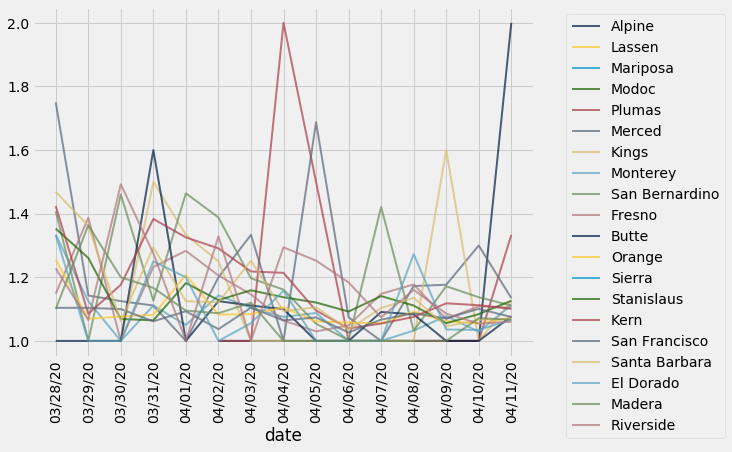

In [120]:
get_rates(cases).tail(14).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

/Users/culler/anaconda3/envs/data8/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/culler/anaconda3/envs/data8/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


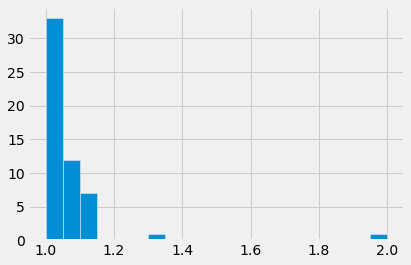

In [121]:
_ = plots.hist(get_rates(cases).take[-1].row(0)[1:], bins=20)

In [122]:
def best_rate(ts, n):
    rates = get_rates(ts).tail(7).order_cols()
    best = rates.labels[-n:]
    return rates.extract(best)

In [123]:
best_rate(cases, 12)

date,Sacramento,Santa Cruz,Shasta,Siskiyou,Sutter,Tehama,Tulare,Tuolumne,Ventura,Yuba,Out of CA,Unassigned
04/04/20,1,1.03509,1.09091,1,1.14286,inf,1,1,1.14689,1.125,nan,nan
04/05/20,1.13333,1.16949,1.41667,1,1,1,1.4321,1,1.08867,1,nan,nan
04/06/20,1.04525,1,1.17647,1.33333,1,1,1.16379,1,1,1.22222,nan,inf
04/07/20,1.13636,1.10145,1.05,1,1,1,1.16296,1,1.09955,1,nan,0.976744
04/08/20,1.10476,1,1.09524,1,1.1875,1,1,0.5,1.0823,1.18182,nan,3.97619
04/09/20,1,1,1.04348,1,1.05263,1,1.07006,1,1.04183,1.15385,nan,0.0239521
04/10/20,1.12586,1.05263,1,1.25,1.85,1,1.20833,1,1.08759,1,nan,1
04/11/20,1,1,1,1,1,1,1,1,1,1,nan,1


In [124]:
def get_new(trend, region):
    return trend['new ' + region][-1]

def get_rate(trend, region):
    return trend['rate ' + region][-1]

def get_val(trend, region):
    return trend[region][-1]

def get_rate_slope(trend, region):
    params, pcov = fit(lin_rate, trend)
    return params[1]

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'current', [get_val(trend, r) for r in regions],
        'new',  [get_new(trend, r) for r in regions],
        'rate', [get_rate(trend, r) for r in regions],
    )
    params = [fit(lin_rate, ts.extract(r).trend().tail(7)) for r in regions]
    smry['eff rate'] = [p[0][0] for p in params]
    smry['delta']    = [p[0][1] for p in params]
    smry['err']      = [p[1][1] for p in params]
    return smry.where(np.isfinite(smry['err']))

In [125]:
case_sum = summary(cases, 'county', counties)
case_sum.sort('delta', descending=True)

/Users/culler/anaconda3/envs/data8/lib/python3.6/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


county,current,new,rate,eff rate,delta,err
Alpine,2,1,2,0.833333,0.0833333,0.0481125
Sutter,37,0,1,1.00432,0.0428023,0.0451565
Kings,9,1,1.125,0.979167,0.0318452,0.0325704
Glenn,3,0,1,0.958333,0.0297619,0.0268408
Madera,32,2,1.06667,0.982937,0.00980726,0.00352037
San Benito,35,1,1.02941,1.0288,0.00943072,0.0249219
Fresno,191,18,1.10405,1.06179,0.00911317,0.00757245
San Luis Obispo,110,6,1.05769,0.999428,0.00627825,0.00247745
Napa,32,0,1,1.05933,0.00545936,0.016532
San Francisco,857,60,1.07528,1.05544,0.0043513,0.00309799


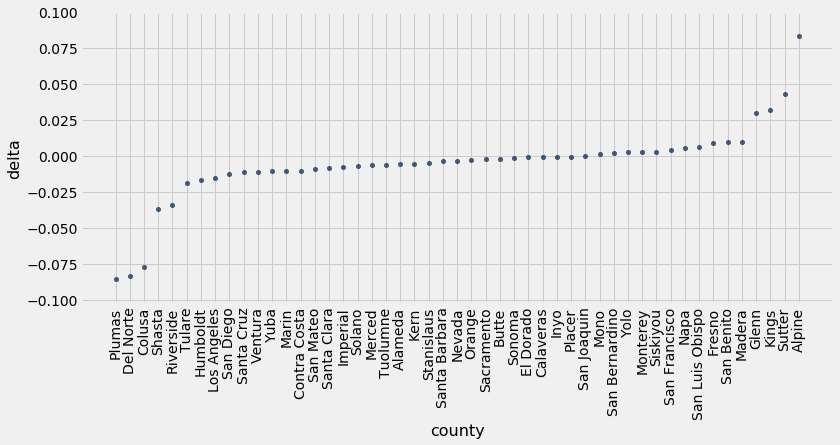

In [126]:
case_sum.select('county', 'delta').sort('delta').scatter('county', width=12)
_ = plots.xticks(rotation=90)

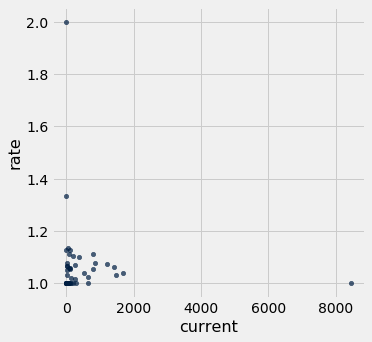

In [127]:
case_sum.scatter('current', 'rate')

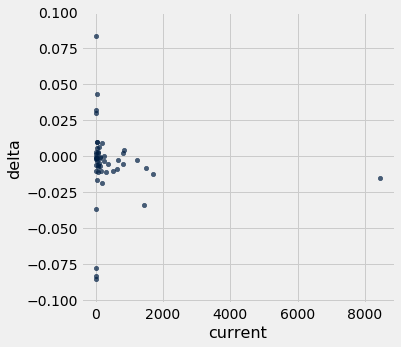

In [128]:
case_sum.scatter('current', 'delta')